<a href="https://colab.research.google.com/github/blufzzz/Dynamic-Texture-3D-CNN/blob/master/3D_CNN_Video_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [0]:
import urllib
import requests
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x570e6000 @  0x7ff0155a72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [0]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 65.5MB/s 
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
from skimage import io
import cv2
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.display import clear_output
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

In [2]:
cd ./gdrive/My\ Drive/Colab Notebooks/two-stream-dyntex-synth

/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth


# Define model

In [0]:
class CNN3D(nn.Module):
  
  def __init__(self):
    
    super(CNN3D, self).__init__()
    
    self.d_conv1 = nn.Conv3d(3,64, (3,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool1 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv2 = nn.Conv3d(64, 128, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool2 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.d_conv3 = nn.Conv3d(128, 256, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool3 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv4 = nn.Conv3d(256, 512, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool4 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
        
    
    self.u_unconv1 = nn.ConvTranspose2d(512, 256, (2,2), stride = 2, bias=True)
    self.u_conv1 = nn.Conv2d(256, 256, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv2 = nn.ConvTranspose2d(256, 128, (2,2), stride = 2, bias=True)
    self.u_conv2= nn.Conv2d(128, 128, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride = 2, bias=True)
    self.u_conv3 = nn.Conv2d(64, 64, (3,3), stride = 1, padding=(1,1), bias=True)

    self.u_unconv4 = nn.ConvTranspose2d(64,3, (1,1), stride = 1, bias=True)
    self.u_conv4 = nn.Conv2d(3, 3, (1,1), stride = 1, bias=True)

    self.relu = nn.LeakyReLU()
        
  def forward(self, x):

    x = self.d_conv1(x)
    self.res1 = x
    x = self.d_pool1(x)
    x = self.relu(x)
    
    x = self.d_conv2(x)
    self.res2 = x
    x = self.d_pool2(x)
    x = self.relu(x)
    
    x = self.d_conv3(x)
    self.res3 = x
    x = self.d_pool3(x)
    x = self.relu(x)
    
    x = self.d_conv4(x)
    self.res4 = x
    x = self.relu(x)
    
    x = x.reshape(1,x.shape[1], x.shape[-1], x.shape[-1])
    
    x = self.u_unconv1(x)
    x = self.u_conv1(x)
    x = self.relu(x)
    
    x = self.u_unconv2(x)
    x = self.u_conv2(x)
    x = self.relu(x)
    
    x = self.u_unconv3(x)
    x = self.u_conv3(x)
    x = self.relu(x)
    
    x = self.u_unconv4(x)
    x = self.u_conv4(x)
    x = self.relu(x)    
    
    return x
  

In [0]:
def get_seq(fold, seq_len):
  
  names = sorted(os.listdir(fold))
  
  n_framesets = len(names) - seq_len + 1
  
  for i in range(n_framesets - 1):
  
    imgs = []
    
    y = io.imread(os.path.join(fold, names[i+seq_len])).transpose(2,0,1)
   
    y = np.expand_dims(y,0)
    
    for name in names[i:i+seq_len]:
  
      imgs += [io.imread(os.path.join(fold, name)).transpose(2,0,1)]
  
    imgs = np.array([imgs]).transpose(0,2,1,3,4)
  
    yield torch.Tensor(imgs), torch.Tensor(y)
    
def deprocess(img_tensor):
  
  return img_tensor[0].detach().cpu().numpy().astype('uint8').transpose(1,2,0)    

# Train model

In [0]:
fold = './data/dynamic_textures/escalator/'

model = CNN3D()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
eps = 1000
freq = 100

losses = []

for ep in tqdm(range(eps)):
  
  print('epoch {}'.format(ep))
  
  for seq,y in get_seq(fold, 6):
    
    seq = seq.cuda()
    y = y.cuda()
    
    optimizer.zero_grad()
    
    pred = model(seq)
    
    loss = torch.norm(y - pred)
    losses += [loss]
    loss.backward()
    
    optimizer.step()
  
  # show
  if ep%freq == 0 and ep > 0:
  
    plt.figure()
    img = pred[0].detach().cpu().numpy().astype('uint8')
    
    img = img.transpose(1,2,0)
    
    plt.imshow(np.clip(img, 0, 255))
    plt.title('epoch {}'.format(ep))
    plt.grid(False)  
    plt.show()
    



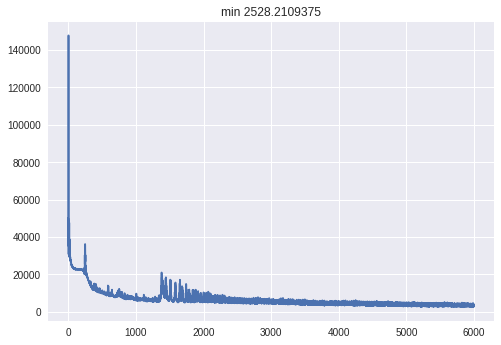

In [8]:
plt.plot(range(len(losses)), losses)
plt.title('min {}'.format(min(losses)))
plt.show()

In [0]:
# torch.save(model.state_dict(), './escalator.pt')

# Use model

In [0]:
texture_type = 'escalator'

In [0]:

model = CNN3D()
model.load_state_dict(torch.load('./{}.pt'.format(texture_type)))
model = model.cuda()

## Generation

In [0]:
fold = './data/dynamic_textures/{}/'.format(texture_type)

target_seq_len = 6
seq_len = 20
path_target = fold

names = sorted(os.listdir(fold))[:-6]

imgs = [imgs_tensor for imgs_tensor, y in get_seq(path_target, target_seq_len)][-1]
imgs = imgs.cuda()

generated_imgs = []

for i in range(seq_len):

  new_img = model(imgs)

  generated_imgs += [deprocess(new_img)]
  imgs = torch.cat([imgs[:,:,list(range(target_seq_len - 1)),:,:,], new_img.view(1,3,1,256,256)], 2).cuda()


## Saving

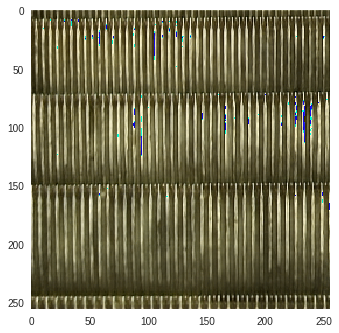

In [9]:
fold_save = './{}0/'.format(texture_type)

while os.path.isdir(fold_save):
  
  number = int(re.findall('\d+',fold_save)[-1]) + 1
  
  fold_save = './{}/'.format(texture_type + str(number)) 
  
os.mkdir(fold_save)

for i,img in enumerate(generated_imgs):
  
  plt.imshow(img)
  plt.grid(False)
  plt.imsave(fold_save + '{}.jpg'.format(i), img)